<a href="https://colab.research.google.com/github/fichel/fast.ai-practice/blob/dev/emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Classifier

We're going to use the Fastai library to classify six types of emotions based on images of people:

* sadness
* anger
* happiness
* fear
* disgust
* surprise

## Downloading the Images

We'll start off downloading images of each emotion. For this, we'll use DuckDuckGo's `duckduckgo_search` package

In [1]:
# install dependencies
! pip install -Uqq fastai duckduckgo_search

     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 96 kB 5.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [3]:
# download images
from duckduckgo_search import ddg_images

ddg_images(keywords='sad person', max_results=2)

[{'title': 'Sad Person - Cliparts.co',
  'image': 'http://cliparts.co/cliparts/di9/rad/di9radxAT.jpg',
  'thumbnail': 'https://tse1.mm.bing.net/th?id=OIP.zfTU9WGLwSbc8hnHw_Gl8wHaDt&pid=Api',
  'url': 'http://cliparts.co/sad-person',
  'height': 1000,
  'width': 2000,
  'source': 'Bing'},
 {'title': '10 Struggles Depressed People Avoid Talking About | Thought Catalog',
  'image': 'https://thoughtcatalog.com/wp-content/uploads/2014/11/shutterstock_143888149.jpg?w=786',
  'thumbnail': 'https://tse2.explicit.bing.net/th?id=OIP.U2gqJhyqhCWpLWlS6ckzmQHaHa&pid=Api',
  'url': 'https://thoughtcatalog.com/shireen-dadkhah/2014/11/10-struggles-depressed-people-avoid-talking-about/',
  'height': 786,
  'width': 786,
  'source': 'Bing'}]

In [9]:
# automating the search
from fastcore.all import *

def search_images(term, max_results):
    return L(ddg_images(keywords=f'{term} person', max_results=max_results)).itemgot('image')

In [5]:
results = search_image('sad', max_results=2); results

(#2) ['http://cliparts.co/cliparts/di9/rad/di9radxAT.jpg','https://thoughtcatalog.com/wp-content/uploads/2014/11/shutterstock_143888149.jpg?w=786']

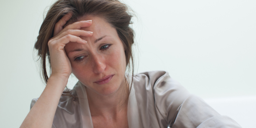

In [6]:
# display the image
from fastai.vision.all import *
from fastdownload import download_url

dest='sad_sample.jpg'
download_url(url=results[0], dest=dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256)

In [ ]:
# download images of each emotion
path = Path('emotions')
search = dict(
    sadness='sad',
    anger='angry',
    happiness='happy',
    fear='fearful',
    disgust='disgusted',
    surprise='surprised'
)

for k, v in search.items():
    dest = path/k
    dest.mkdir(parents=True, exist_ok=True)
    download_images(dest, urls=search_images(v, max_results=100))
    # resize_images()

In [10]:
resize_images?